Extract ranking, song, song url, band singer, band singer url

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd


# Make a GET request to fetch the raw HTML content

# print(soup.prettify()) # print the parsed data of html
# print(soup.title.text)
# print(soup.table)

# In the table there are three columns. So for 1st "td" would mean rank and second would mean title of the song and 3rd is the artist
# Column 1 = Rank
# Column 2 = Title
# Column 3 = Artist

#We build a list of dictionaries for every year. Every dictionary will have the rank, the title, the tile_url, artist, artist_url
# We run a trial with 1970 and we compute for 1992 - 2014

#In some cases there might be more than one singer for a particular song. in those cases we have to put the singers separately in an array
#in some cases the url of the band would not be given

def create_dictionary(year):
  url = "https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_"
  url = url + str(year)
  html_content = requests.get(url).text
  soup = BeautifulSoup(html_content, "lxml") 
  find_table = soup.find('table', class_='wikitable')
  list_of_top_songs = []
  for link in find_table.find_all('tr'):
    d = {}
    i = 0
    for ele in link.find_all('td'):
      i += 1
      if(i == 1):
        d['ranking'] = int(ele.text)
      elif(i == 2):
        l = ele.find_all('a')
        if(len(l) > 1):
          title_name = []
          title_url = []
          s = '" '
          for j in range(len(l)):
            title_url.append(l[j]['href'])
            title_name.append(l[j].text)
            if(j == len(l)-1):
              s = s + l[j].text + ' "' 
            else:
              s = s + l[j].text + ' " / " '
          d['song'] = title_url
          d['song_url'] = title_name
          # d['title_text'] = s
        else:
          song_list = []
          url_list = []
          if(ele.a == None): 
            song_list.append(ele.text)
            d['song'] = song_list
            # d['title_text'] = '" ' + ele.text + ' "'
            url_list.append("None")
            d['song_url'] = url_list
          else:
            song_list.append(ele.text)
            d['song'] = song_list
            # d['title_text'] = '" ' + ele.text + ' "'
            url_list.append(ele.a['href'])
            d['song_url'] = url_list
      elif(i == 3):
        l = ele.find_all('a')
        if(len(l) > 1):
          singer_name = []
          singer_url = []
          for j in range(len(l)):
            singer_url.append(l[j]['href'])
            singer_name.append(l[j].text)
          d['band_singer'] = singer_name
          d['band_url'] = singer_url 
        else:
          singer_name = []
          singer_url = []
          if(ele.a == None):
            singer_name.append(ele.text)
            d['band_singer'] = singer_name
            singer_url.append("None")
            d['band_url'] = singer_url
          else:
            s = ele.text[:-1]
            singer_name.append(s)
            d['band_singer'] = singer_name
            singer_url.append(ele.a['href'])
            d['band_url'] = singer_url

    if(d != {}):
      d['year'] = year
      list_of_top_songs.append(d)
  list_of_top_songs = preprocess_artist(list_of_top_songs)
  list_of_top_songs = preprocess_song(list_of_top_songs)
  list_of_top_songs = extract_genre(list_of_top_songs) 
  return list_of_top_songs
  
# list_of_top_songs = create_dictionary(2008)

# for ind in list_of_top_songs:
#   print(ind["song_url"],len(ind["song_url"]))


Preprocessing artist and songs

In [2]:
import copy
def preprocess_artist(list_of_top_songs):
  add_list = []
  remove_list = []
  for ind in list_of_top_songs:
    ind_row = copy.deepcopy(ind)
    if len(ind['band_singer']) > 1:
      remove_list.append(ind)
      for m in range(len(ind['band_singer'])):
        q = ind['band_singer'][m]
        if('\n' in q):
          q = q[:-2]
        p = ind['band_url'][m]
        ind_row['band_singer'] = q
        ind_row['band_url'] = p
        add_list.append(ind_row)
    else:
      q = ind['band_singer'][0]
      if('\n' in q):
        q = q[:-2]
      p = ind['band_url'][0]
      ind['band_singer'] = q
      ind['band_url'] = p
  list_of_top_songs.extend(add_list)
  for rem_ele in remove_list:
    list_of_top_songs.remove(rem_ele)
  
  return list_of_top_songs

def preprocess_song(list_of_top_songs):
  remove_list = []
  for ind in list_of_top_songs:
    q = ind['song']
    p = ind['song_url']
    if(len(p[0]) < 5):
      remove_list.append(ind)
      continue
    ind['song'] = q[0]
    ind['song_url'] = p[0]
  for ele in remove_list:
    list_of_top_songs.remove(ele) 
  return list_of_top_songs



Extracting genre list

In [3]:
import requests
import copy
def extract_genre(list_of_top_songs):
  sample_genre = []
  for i in list_of_top_songs:
    print(i['song'])
    sp = copy.deepcopy(i)
    sp['genre_list'] = ''
    url = "https://en.wikipedia.org/" + i['song_url']
    html_content = requests.get(url).text
    soup = BeautifulSoup(html_content,"lxml")
    find_table = soup.find('table',class_="infobox vevent")
    if(find_table != None):
      gen = ''
      for link in find_table.find_all('tr'):
        for ele in link.find_all('td'):
          sample = str(ele)
          if("category hlist" in sample):
            gen = ele.text
      # print("----------------")
      genre_list = get_genre_list(gen)
      # print(genre_list)
      # print(type(genre_list))
      sp['genre_list'] = genre_list
      sample_genre.append(sp)
  return sample_genre

Preprocessing genre

In [4]:
def get_genre_list(genre):
  if(genre == ''):
    return []
  if('\n' in genre):
    genre = genre.replace('\n','*')
  if('[1]' in genre):
    genre = genre.replace('[1]','*')
  if('[2]' in genre):
    genre = genre.replace('[2]','*') 
  if('[3]' in genre):
    genre = genre.replace('[3]','*') 
  if('[4]' in genre):
    genre = genre.replace('[4]','*') 
  if('[5]' in genre):
    genre = genre.replace('[5]','*') 
  if('[6]' in genre):
    genre = genre.replace('[6]','*')
  if('r&b' in genre):
    genre = genre.replace('r&b','*r&b*')   
  if('R&b' in genre):
    genre = genre.replace('R&b','*r&b*')
  if(',' in genre):
    genre = genre.replace(',','*')  
  gen = genre.split("*")
  genre_list = []
  for i in gen:
    if i != '':
      i = i.capitalize()
      genre_list.append(i)
  return genre_list

Extracting billboard top charts from 1947 to 2018

In [5]:
import time
complete_data = []
# 1947,2019
for k in range(1947,2019):
  if(k == 1957 or k == 1958 or k == 1969):
    continue
  print("Parsing year "+str(k))
  top_list = create_dictionary(k)
 
  print("---------------------------------------------------------------")
  print("***************************************************************")
  complete_data.extend(top_list)
  time.sleep(1)
# print(len(complete_data))

Streaming output truncated to the last 5000 lines.
"Bridge Over Troubled Water"
"(They Long to Be) Close to You"
"American Woman"
"Raindrops Keep Fallin' on My Head"
"War"
"Ain't No Mountain High Enough"
"I'll Be There"
"Get Ready"
"Let It Be"
"Band of Gold"
"Mama Told Me (Not to Come)"
"Everything Is Beautiful"
"Make It with You"
"Hitchin' a Ride"
"ABC"
"The Love You Save"
"Cracklin' Rosie"
"Candida"
"Thank You (Falettinme Be Mice Elf Agin)"
"O-o-h Child"
"Spirit in the Sky"
"Lay Down (Candles in the Rain)"
"Ball of Confusion (That's What the World Is Today)"
"Love on a Two-Way Street"
"Which Way You Goin' Billy?"
"All Right Now"
"I Want You Back"
"Julie, Do Ya Love Me"
"Green-Eyed Lady"
"Signed, Sealed, Delivered I'm Yours"
"Ride Captain Ride"
"Venus"
"Instant Karma!"
"Patches"
"Lookin' out My Back Door"
"Rainy Night in Georgia"
"Give Me Just a Little More Time"
"Love Grows (Where My Rosemary Goes)"
"The Long and Winding Road"
"Snowbird"
"Reflections of My Life"
"Hey There Lonely Gir

In [6]:
df = pd.DataFrame(complete_data)
df_back_up = pd.DataFrame(complete_data)
space = '     '
print("Ranking      Song          Song url            band_singer              band_url         year                                        ")
for i in range(1):
  print(df.loc[i,'ranking'],space,df.loc[i,'song'],space,df.loc[i,'song_url'], space,df.loc[i,'band_singer'], space,df.loc[i,'band_url'], space,df.loc[i,'year'])

Ranking      Song          Song url            band_singer              band_url         year                                        
1       "Near You"       /wiki/Near_You       Francis Craig       /wiki/Francis_Craig       1947


Maximum number of appeareances by a singer in billboard

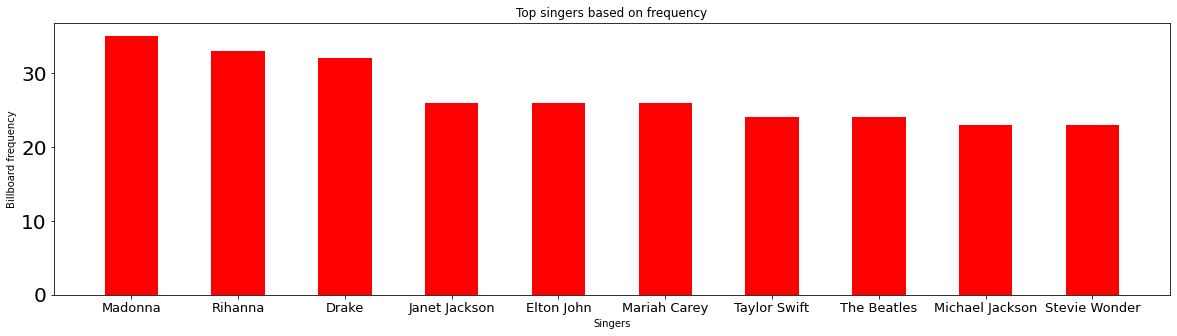

In [9]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=20) 

df_singer = df.groupby('band_singer').agg('count')
# print(df_singer.sort_values(by=[]))

dd = df.groupby('band_singer').size()
top_10_count = dd.sort_values(ascending=False)[:10]

count = []
singer = []
for items in top_10_count.iteritems():
  singer.append(items[0])
  count.append(items[1])

fig = plt.figure(figsize=(20,5))
plt.bar(singer,count,color='red',width=0.5)

plt.xlabel("Singers")
plt.ylabel("Billboard frequency")
plt.title("Top singers based on frequency")
plt.show()
fig.savefig('top_singers_frquency.png')

Cumulative ranking for top 10 singers

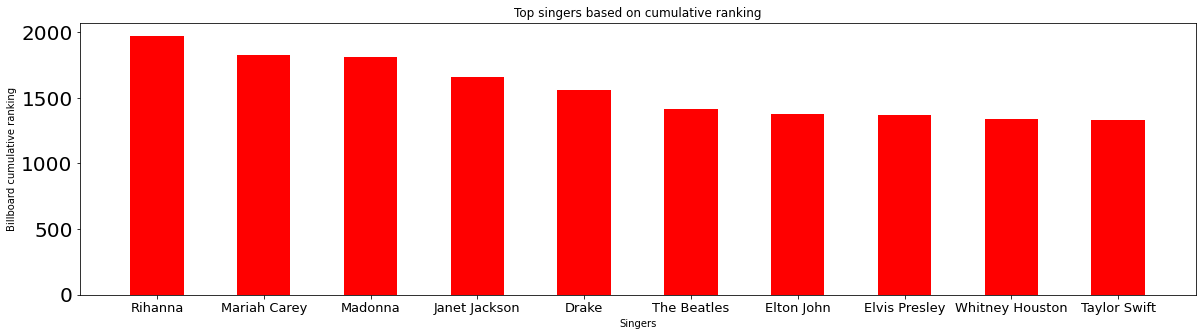

In [10]:
# import pandas as pd
df['cumulative_ranking'] = 101 - df['ranking']

cumulative_df = df.groupby(['band_singer']).sum()
cumulative_df = cumulative_df.sort_values(by='cumulative_ranking',ascending=False)[:10]


singer = list(cumulative_df.index)
cumulative_score = list(cumulative_df['cumulative_ranking'])

fig2 = plt.figure(figsize=(20,5))
plt.bar(singer,cumulative_score,color='red',width=0.5)

plt.xlabel("Singers")
plt.ylabel("Billboard cumulative ranking")
plt.title("Top singers based on cumulative ranking")
plt.show()
fig2.savefig('top_singers_cumulative_score.png')

In [ ]:
# best song in each year
number_uno = df.loc[df['ranking'] == 1][['year','song','band_singer']]
print(number_uno)

      year                 song        band_singer
0     1947           "Near You"      Francis Craig
43    1949  "Riders in the Sky"      Vaughn Monroe
72    1950    "Goodnight Irene"        The Weavers
78    1951          "Too Young"      Nat King Cole
104   1952         "Blue Tango"     Leroy Anderson
...    ...                  ...                ...
5504  2014              "Happy"  Pharrell Williams
5671  2015        "Uptown Funk"         Bruno Mars
5704  2016      "Love Yourself"      Justin Bieber
5804  2017       "Shape of You"         Ed Sheeran
5904  2018         "God's Plan"              Drake

[66 rows x 3 columns]


In [9]:
unique_genre = []
for ind in df.genre_list:
  lis = []
  for j in ind:
    lis.append(j)
  unique_genre.extend(lis)
print(len(list(set(unique_genre))))

1063


In [ ]:
for each_genre in unique_genre:
    df[each_genre] = [True if each_genre in each else False for each in list(df.genre_list)]

Most popular genre of all time

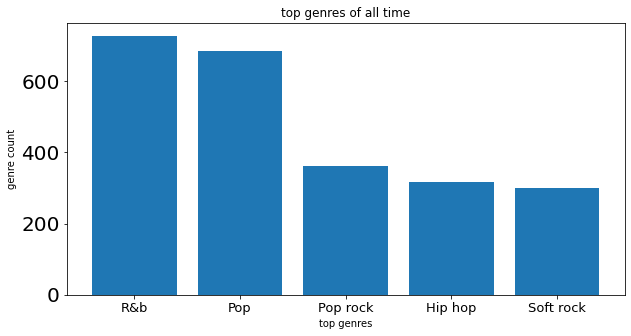

In [11]:
def most_popular_genre_of_all_time():
  d = {}
  for i in df['genre_list']:
    for j in i:
      if(j in d):
        d[j] += 1
      else:
        d[j] = 1
  d = dict(sorted(d.items(),key = lambda x : x[1],reverse=True))

  all_count = 0
  all_genre_title = []
  all_genre_count = []
  for inde in d:
    if(all_count == 5):
      break
    all_genre_title.append(inde)
    all_genre_count.append(d[inde])
    all_count += 1

  fig = plt.figure(figsize=(10,5))
  plt.bar(all_genre_title,all_genre_count)
  plt.xlabel("top genres")
  plt.ylabel("genre count")
  plt.title("top genres of all time")
  fig.savefig('top_genres_of_all_time.png')
  plt.show()

most_popular_genre_of_all_time()

Most popular genre for a period of time

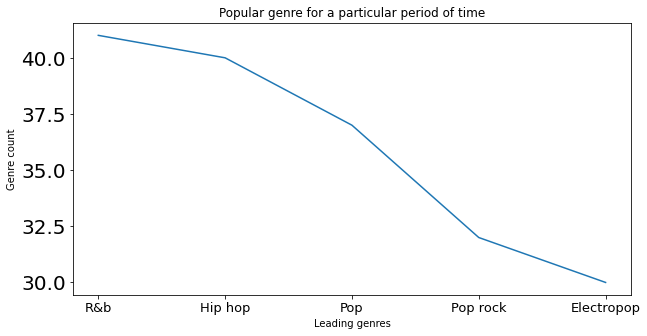

In [12]:
def most_popular_genre(year_begin, year_end):
  years = []
  g_list = []
  for y in range(year_begin, year_end + 1):
    years.append(y)
  #To get the genres of the books published in the given range
  for i in list(df[df["year"].isin(years)]["genre_list"]):
    for j in i:
      g_list.append(j)
  
  dict_count = {}
  for ge in g_list:
    if ge not in dict_count:
      dict_count[ge] = 1
    else:
      dict_count[ge] += 1
  
  dict_count = dict(sorted(dict_count.items(),key = lambda x : x[1], reverse = True))
  count_genre = 0
  song_genre_list = []
  song_genre_count = []

  for ge in dict_count:
    if(count_genre == 5):
      break
    song_genre_list.append(ge)
    song_genre_count.append(dict_count[ge])
    count_genre += 1

  fig = plt.figure(figsize=(10,5))
  plt.plot(song_genre_list,song_genre_count)
  plt.xlabel("Leading genres")
  plt.ylabel("Genre count")
  plt.title("Popular genre for a particular period of time")
  fig.savefig('popular_genres_in_a_paticular_period.png')
  plt.show()
most_popular_genre(2012,2015)

Top singers for a particular period of time

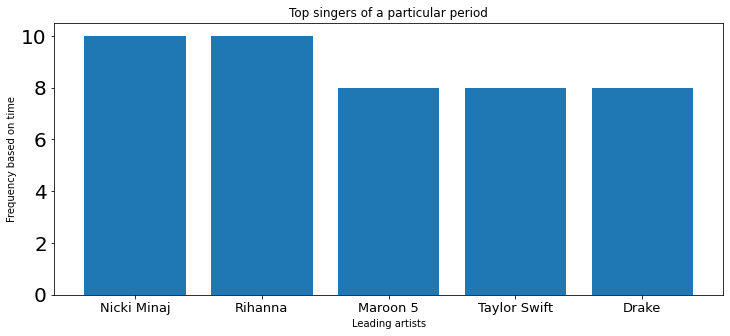

In [13]:
def popular_artist(start_year, end_year):
  years = [y for y in range(start_year, end_year + 1)]
  
  artist_df = list(df[df['year'].isin(years)]['band_singer'])
  dict_artist = {}

  for items in artist_df:
    if(items in dict_artist):
      dict_artist[items] += 1
    else:
      dict_artist[items] = 1
  
  dict_artist = dict(sorted(dict_artist.items(),key = lambda x : x[1], reverse = True))
  artist_count = []
  artist = []
  count = 0
  for i in dict_artist:
    if(count == 5):
      break
    artist.append(i)
    artist_count.append(dict_artist[i])
    count += 1
  fig2 = plt.figure(figsize=(12,5))
  plt.bar(artist, artist_count)
  plt.xlabel("Leading artists")
  plt.ylabel("Frequency based on time")
  plt.title("Top singers of a particular period")
  fig.savefig('top_singers_in_a_period.png')
popular_artist(2012,2015)


Genre trend over the years

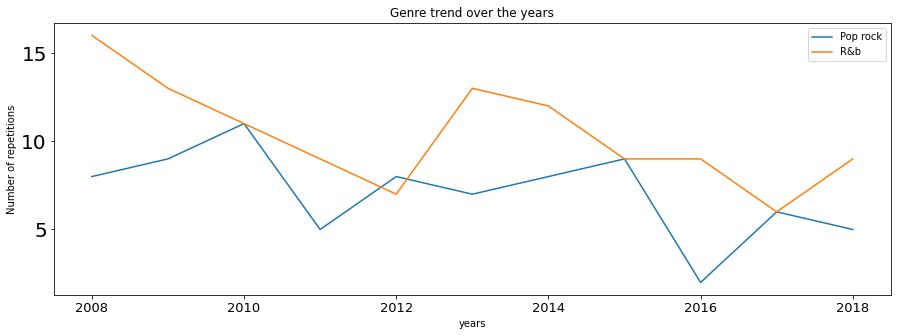

In [14]:
def genre_trend_comparison(list_of_genres, start_year, end_year):
  time_list=[y for y in range(start_year, end_year + 1)]
  d = {}
  for genre in list_of_genres:
    d[genre] = []

  for y in time_list:
    new_list = []
    for i in list(df[df['year'] == y]['genre_list']):
      for j in i:
        if(j in list_of_genres):
          new_list.append(j)
    di = {}
    for k in new_list:
      if(k in di):
        di[k] += 1
      else:
        di[k] = 1
    
    for m in di:
      array = d[m]
      array.append(di[m])
      d[m] = array 

  s = []

  for i in list_of_genres:
    q = d[i]
    s.append(q)
  fig,axes = plt.subplots(figsize=(15,5))
  for i,j in enumerate(list_of_genres):
    axes.plot(time_list,s[i],label=j)
  axes.set_xlabel('years')
  axes.set_ylabel('Number of repetitions')
  axes.set_title("Genre trend over the years")
  axes.legend(loc=0)
  fig.savefig('genre_comparison.png')

list_of_genres = ['Pop rock','R&b']
genre_trend_comparison(list_of_genres,2008,2018)